In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [182]:
data = pd.read_csv('../data/training_data.csv')
data['month'] = data['month'].astype('category')
data['day_of_week'] = data['day_of_week'].astype('category')
# data["hour_of_day"] = data["hour_of_day"].astype('category')
data["holiday"] = data["holiday"].astype('category')
data["weekday"] = data["weekday"].astype('category')
data["summertime"] = data["summertime"].astype('category')
data['increase_stock'] = data['increase_stock'].astype('category')
data['is_high_demand'] = data['increase_stock'].apply(lambda entity: 1 if entity == 'high_bike_demand' else 0)
data['is_high_demand'] = data['is_high_demand'].astype('int')

data["daytime"] = data.hour_of_day.apply(lambda h: 1 if h in range(7, 20) else 0)
data["rushhour"] = data.hour_of_day.apply(lambda h: 1 if h in range(15, 20) else 0)

data = data.drop('snow', axis=1) #no information in this column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   hour_of_day     1600 non-null   int64   
 1   day_of_week     1600 non-null   category
 2   month           1600 non-null   category
 3   holiday         1600 non-null   category
 4   weekday         1600 non-null   category
 5   summertime      1600 non-null   int64   
 6   temp            1600 non-null   float64 
 7   dew             1600 non-null   float64 
 8   humidity        1600 non-null   float64 
 9   precip          1600 non-null   float64 
 10  snowdepth       1600 non-null   float64 
 11  windspeed       1600 non-null   float64 
 12  cloudcover      1600 non-null   float64 
 13  visibility      1600 non-null   float64 
 14  increase_stock  1600 non-null   category
 15  is_high_demand  1600 non-null   int64   
 16  daytime         1600 non-null   int64   
 17  rushhour      

In [183]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y = data['is_high_demand']
data_weather = data.drop(
    columns=['is_high_demand', 'increase_stock', 'hour_of_day', 'day_of_week', 'month', 'holiday', 'weekday','daytime','rushhour'])
X = scaler.fit_transform(data_weather)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=123)

weather_model = LinearRegression()
weather_model.fit(X_train, y_train)
print(pd.DataFrame(X).describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   summertime  1600 non-null   int64  
 1   temp        1600 non-null   float64
 2   dew         1600 non-null   float64
 3   humidity    1600 non-null   float64
 4   precip      1600 non-null   float64
 5   snowdepth   1600 non-null   float64
 6   windspeed   1600 non-null   float64
 7   cloudcover  1600 non-null   float64
 8   visibility  1600 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 112.6 KB
None


In [184]:
print(f'ceofs')
print(weather_model.intercept_)
print(weather_model.coef_)

ceofs
-0.8138192466580598
[-5.56042822e-04  6.31851025e-02 -5.21309866e-02  6.49687899e-03
 -1.10383706e-02  6.86816015e-03 -5.95565495e-05  7.78956846e-04
 -1.72291318e-03]
-0.0017229131847425094


In [191]:
predictions = weather_model.predict(X_test)
pd.DataFrame(predictions).describe()

,0
count,160.000000
mean,0.175356
std,0.184436
min,-0.164667
25%,0.040850
50%,0.148143
75%,0.275019
max,0.710425


In [192]:
errors = y_test - predictions
sns.histplot(errors)

array([-0.13550696,  0.440059  ,  0.12344861,  0.21471269])

<Axes: xlabel='is_high_demand', ylabel='Count'>

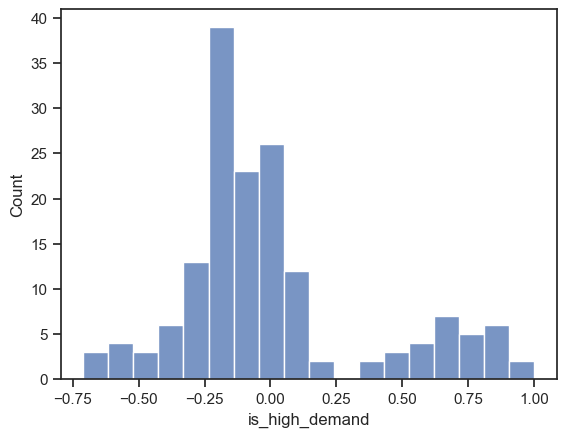

In [193]:
data['weather_score'] = weather_model.predict(X)
data.describe()

In [199]:

data_subset = data[['is_high_demand','temp','weather_score','hour_of_day','rushhour','daytime']]
covariates = data_subset.columns[data_subset.columns != 'is_high_demand']
plt.figure(figsize=(10, 10), dpi=500)
sns.set(style="ticks")
pp = sns.pairplot(data_subset,
                  vars=covariates,
                  hue='is_high_demand',
                  markers=["o", "s"],
                  plot_kws={"s":8},
                  palette="viridis")
pp.map_lower(sns.kdeplot, fill=True)
pp.map_diag(sns.histplot, kde=True)

,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snowdepth,windspeed,cloudcover,visibility,increase_stock,is_high_demand,daytime,rushhour,weather_score,weather_rush
0,5,5,1,0,0,0,-7.2,-15.0,53.68,0.0,0.0,16.3,31.6,16.0,low_bike_demand,0,0,0,-0.141957,-0.000000
1,21,4,1,0,1,0,-1.3,-12.8,40.97,0.0,0.0,23.9,85.7,16.0,low_bike_demand,0,0,0,0.075260,0.000000
2,21,3,8,0,1,1,26.9,21.8,73.39,0.0,0.0,0.0,81.1,16.0,low_bike_demand,0,0,0,0.261261,0.000000
3,1,6,1,0,0,0,3.1,-4.0,59.74,0.0,0.0,19.2,0.0,16.0,low_bike_demand,0,0,0,-0.050008,-0.000000
4,17,0,3,0,1,0,11.7,-11.4,18.71,0.0,0.0,10.5,44.6,16.0,low_bike_demand,0,1,1,0.647846,64.784583


<Figure size 5000x5000 with 0 Axes>

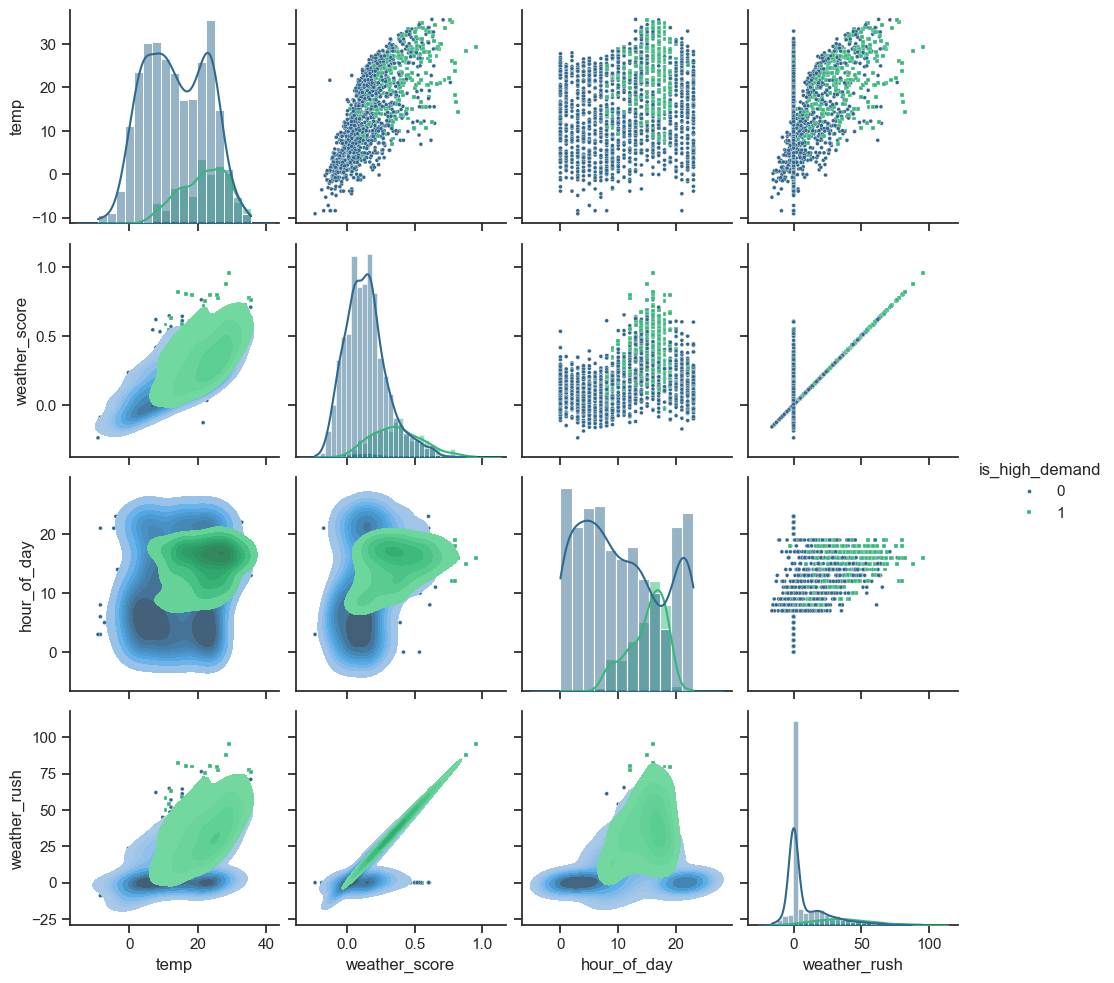

In [200]:
corr_matrix = data_subset.corr()
cmap = sns.color_palette('viridis', as_cmap=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# Draw the heatmap with the mask and aspect ratio
sns.heatmap(corr_matrix, 
            mask=mask, 
            cmap=cmap, 
            vmax=.3,
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5}, annot=True)

<Axes: >

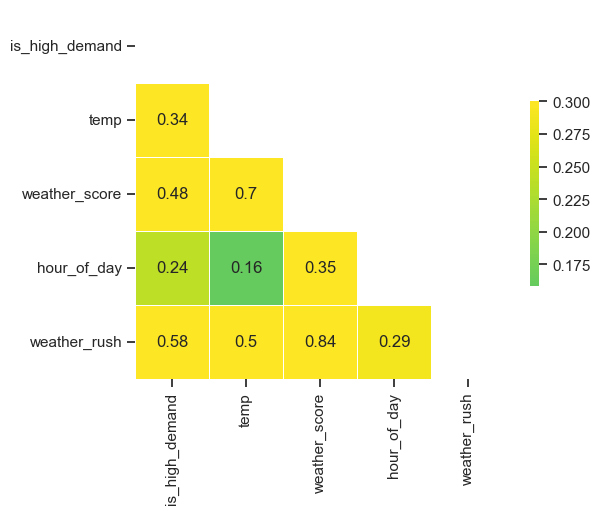

In [201]:
sns.violinplot(data=data_subset,x='daytime',y='temp', hue='is_high_demand', palette='viridis', linewidth=.8)